In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from Graphs import create_barplot, sns_scatterplot
import Graphs
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Load dataset
data = pd.read_csv("ev_charging_patterns.csv")

c:\Users\mjalb\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Data Preprocessing and Time Feature Extraction

data.dropna(inplace=True)

# Extracting detailed time features from Charging Start Time
# Convert Charging Start Time to datetime format
data['Charging Start Time'] = pd.to_datetime(data['Charging Start Time'])
data['Charging End Time'] = pd.to_datetime(data['Charging End Time'])

# Extract hour, 15-minute interval, weekday/weekend, and month from Charging Start Time
data['Hour'] = data['Charging Start Time'].dt.hour
data['Weekday'] = data['Charging Start Time'].dt.weekday
data['Is Weekend'] = data['Weekday'] >= 5
data['Weekday'] = data['Charging Start Time'].dt.day_name()
data['Month'] = data['Charging Start Time'].dt.month

# Categorize Time of Day into more specific periods
def categorize_time_of_day(hour):
    if 7 <= hour < 9:
        return "Morning Peak"
    elif 9 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 14:
        return "Midday"
    elif 14 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 19:
        return "Evening Peak"
    elif 19 <= hour < 23:
        return "Evening"
    else:
        return "Late Night"

data['Time of Day'] = data['Hour'].apply(categorize_time_of_day)

# Categorize Time of Day as an ordered categorical variable
time_order = ["Morning Peak", "Morning", "Midday", "Afternoon", "Evening Peak", "Evening", "Late Night"]
data['Time of Day'] = pd.Categorical(data['Time of Day'], categories=time_order, ordered=True)

# Calculate unit cost (USD per kWh) for each charging session
data['Unit Cost (USD per kWh)'] = data['Charging Cost (USD)'] / data['Energy Consumed (kWh)']

# Use MAD to detect outliers in Unit Cost
mad_cost = np.abs(data['Unit Cost (USD per kWh)'] - data['Unit Cost (USD per kWh)'].median()).median()
outliers_cost = np.abs(data['Unit Cost (USD per kWh)'] - data['Unit Cost (USD per kWh)'].median()) > 10 * mad_cost
data = data[~outliers_cost]

# Time-based Analysis

In [3]:
# 1. Peak Analysis (Time Dimension)

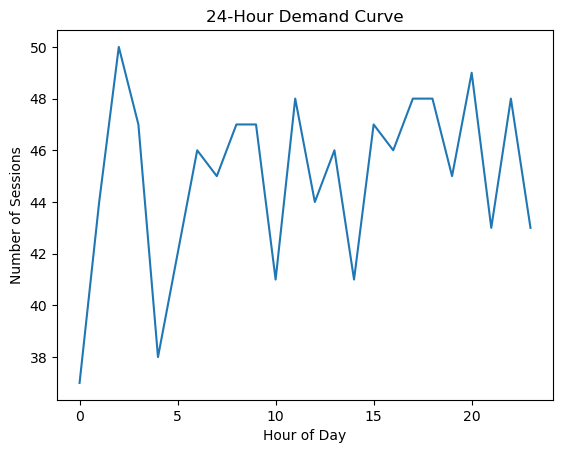

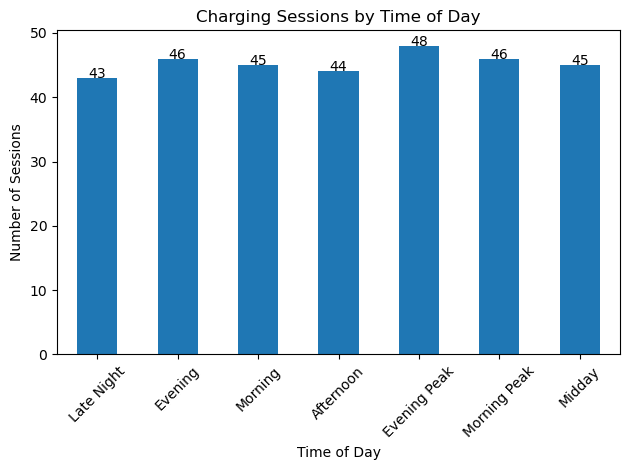

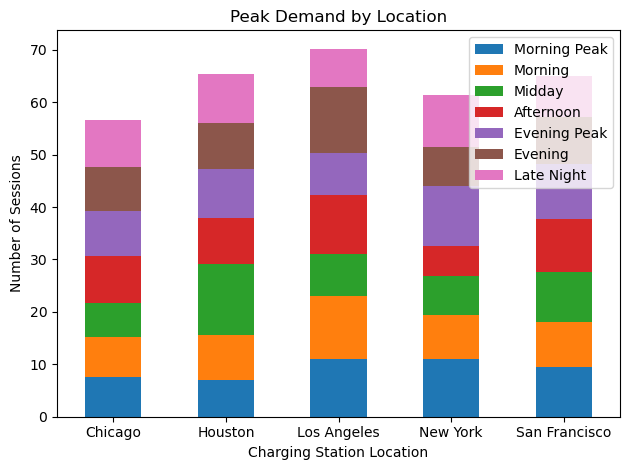

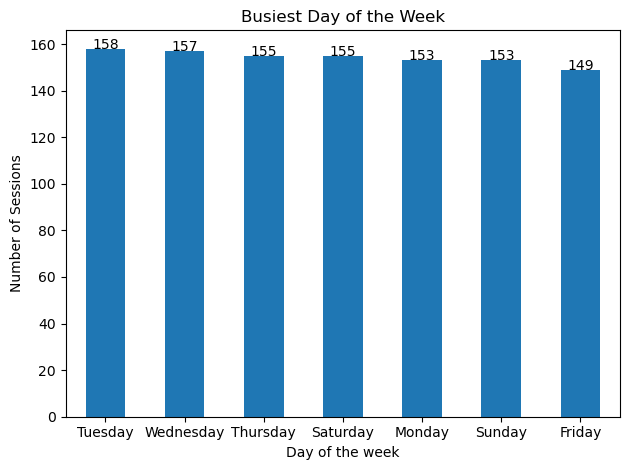

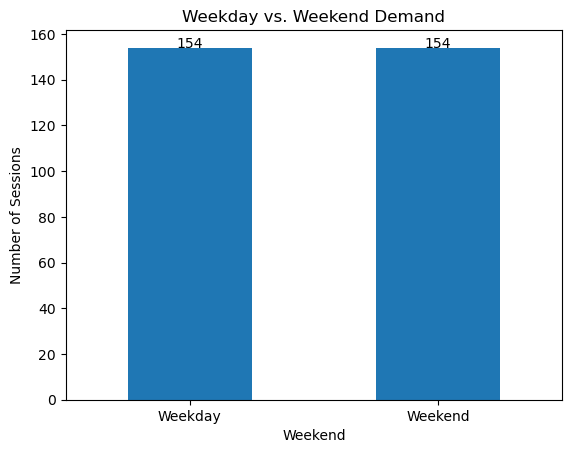

In [4]:
# 1.1 Charging Sessions Count by Time (Univariate Analysis)

# 1.1.1 Count charging sessions by hour (24-hour demand curve)
hourly_sessions = data.groupby('Hour').size()
hourly_sessions.plot(kind='line', title='24-Hour Demand Curve')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.show()

def divide_by_hours(x):
    x['Morning Peak'] = x['Morning Peak'] / 2
    x['Evening Peak'] = x['Evening Peak'] / 2
    x['Morning'] = x['Morning'] / 3
    x['Midday'] = x['Midday'] / 2
    x['Afternoon'] = x['Afternoon'] / 3
    x['Evening'] = x['Evening'] / 4
    x['Late Night'] = x['Late Night'] / 8

# 1.1.2 Count charging sessions by Time of Day
time_of_day_sessions = data['Time of Day'].value_counts()
divide_by_hours(time_of_day_sessions)
# Remove the decimal part of the values
time_of_day_sessions = time_of_day_sessions.astype(int)
create_barplot(time_of_day_sessions, 'Time of Day', 'Number of Sessions', 'Charging Sessions by Time of Day', rotation=45)

# 1.1.3 Analyzing peak demand differences by charging station location
peak_by_location = data.groupby(['Charging Station Location', 'Time of Day']).size().unstack()
divide_by_hours(peak_by_location)
create_barplot(peak_by_location, 'Charging Station Location', 'Number of Sessions', 'Peak Demand by Location', stacked=True, annotate=False, legend=True)

# 1.1.4 Find the busiest day
busiest_day = data['Weekday'].value_counts()
create_barplot(busiest_day, 'Day of the week', 'Number of Sessions', 'Busiest Day of the Week')

# 1.1.5 Compare demand between weekdays and weekends
weekday_sessions = data.groupby('Is Weekend').size()
# Divide by 5 and 2 to get average number of sessions per weekday and weekend
weekday_sessions[0] = int(weekday_sessions[0] / 5)
weekday_sessions[1] = int(weekday_sessions[1] / 2)
weekday_sessions.plot(kind='bar', title='Weekday vs. Weekend Demand')
plt.xlabel('Weekend')
plt.ylabel('Number of Sessions')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
for i, v in enumerate(weekday_sessions):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

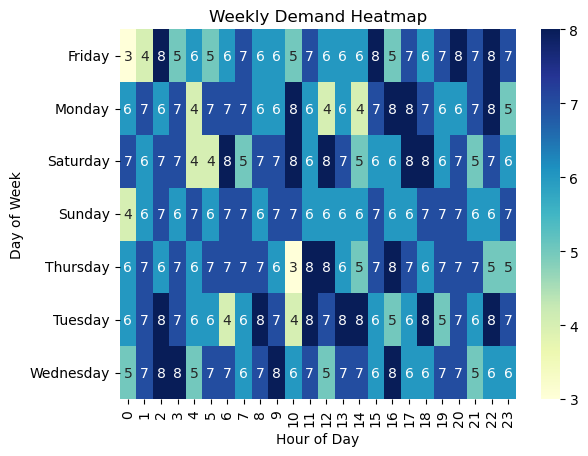

In [5]:
# 1.2 Bivariate Analysis
# Weekly demand heatmap
weekly_demand = data.pivot_table(index='Weekday', columns='Hour', values='User ID', aggfunc='count').fillna(0)
sns.heatmap(weekly_demand, cmap='YlGnBu', annot=True)
plt.title('Weekly Demand Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

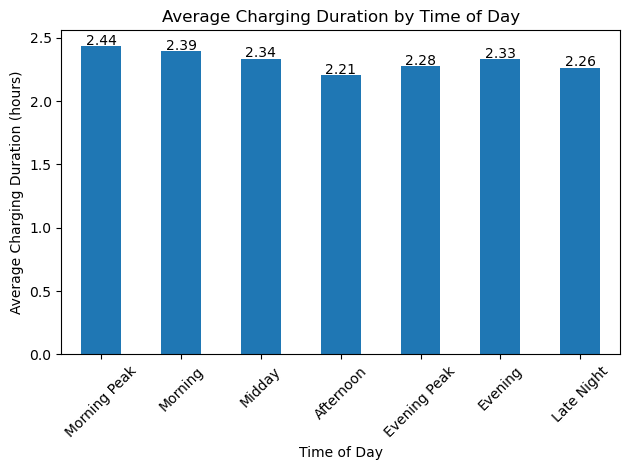

In [6]:
# 1.3 Average charging duration by Time of Day
avg_duration = data.groupby('Time of Day')['Charging Duration (hours)'].mean()
create_barplot(avg_duration, 'Time of Day', 'Average Charging Duration (hours)', 'Average Charging Duration by Time of Day', rotation=45)

In [7]:
# 2. Unit Cost Analysis

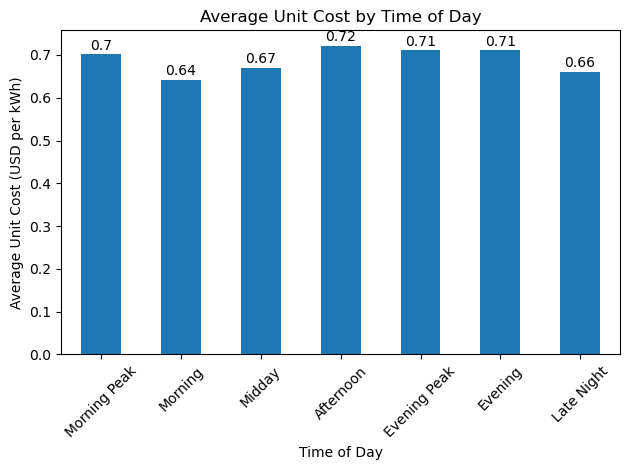

In [8]:
# 2.1 Average Unit Cost by Time of Day (show exact figures on the plot)
avg_unit_cost = data.groupby('Time of Day')['Unit Cost (USD per kWh)'].mean()
create_barplot(avg_unit_cost, 'Time of Day', 'Average Unit Cost (USD per kWh)', 'Average Unit Cost by Time of Day', rotation=45)

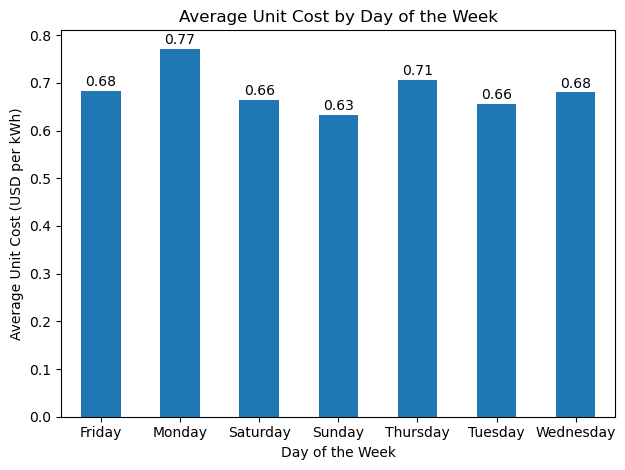

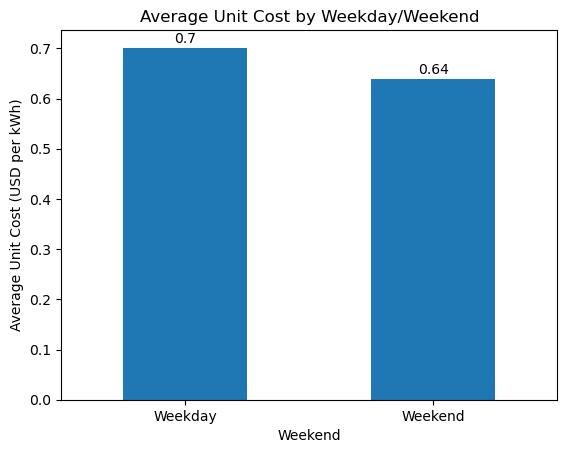

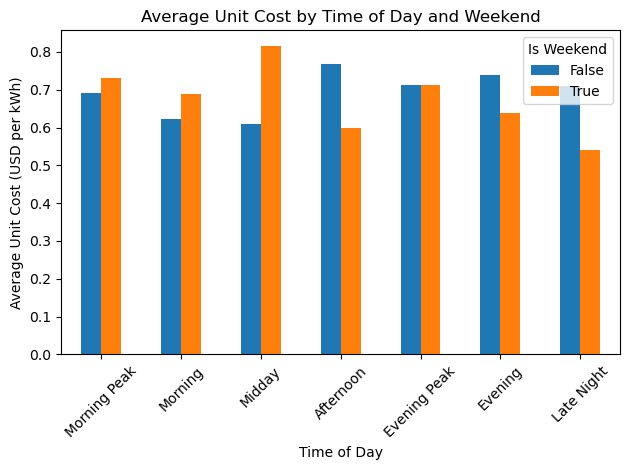

In [9]:
# 2.2 Cost Analysis by Day
# Average Unit Cost by Day of the Week
avg_unit_cost_weekday = data.groupby('Day of Week')['Unit Cost (USD per kWh)'].mean()
create_barplot(avg_unit_cost_weekday, 'Day of the Week', 'Average Unit Cost (USD per kWh)', 'Average Unit Cost by Day of the Week')

# Average Unit Cost by Weekday/Weekend
avg_unit_cost_weekend = data.groupby('Is Weekend')['Unit Cost (USD per kWh)'].mean()
avg_unit_cost_weekend.plot(kind='bar', title='Average Unit Cost by Weekday/Weekend')
plt.xlabel('Weekend')
plt.ylabel('Average Unit Cost (USD per kWh)')
plt.xticks([0, 1], ['Weekday', 'Weekend'], rotation=0)
for i, v in enumerate(avg_unit_cost_weekend):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')
plt.show()

# Compare average charging cost by Time of Day and between weekdays and weekends
time_costs = data.groupby(['Time of Day', 'Is Weekend'])['Unit Cost (USD per kWh)'].mean().unstack()
create_barplot(time_costs, 'Time of Day', 'Average Unit Cost (USD per kWh)', 'Average Unit Cost by Time of Day and Weekend', annotate=False, rotation=45)

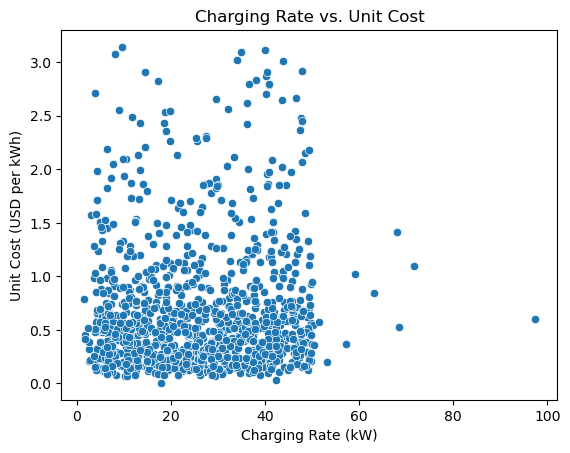

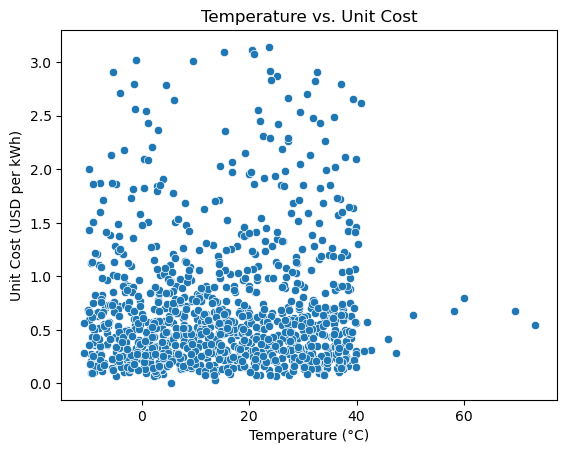

In [10]:
# 2.3 Factors Affecting Charging Costs
# Charging Rate impact on unit cost
sns_scatterplot('Charging Rate (kW)', 'Unit Cost (USD per kWh)', data, 'Charging Rate vs. Unit Cost', 'Charging Rate (kW)', 'Unit Cost (USD per kWh)')

# Temperature impact on unit cost
sns_scatterplot('Temperature (°C)', 'Unit Cost (USD per kWh)', data, 'Temperature vs. Unit Cost', 'Temperature (°C)', 'Unit Cost (USD per kWh)')

# Location Based Analysis

In [11]:
data_name = 'ev_charging_patterns.csv'
data = pd.read_csv(data_name)
data = data.dropna()
data

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,22.081164,Evening,Sunday,39.204102,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,5.067806,Evening,Tuesday,31.456375,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver
1317,User_1318,Nissan Leaf,100.000000,Station_374,New York,2024-02-24 21:00:00,2024-02-24 23:03:00,18.895102,3.267122,45.482066,37.255002,Evening,Tuesday,71.903081,78.678879,226.519258,20.358761,5.0,DC Fast Charger,Commuter
1318,User_1319,Chevy Bolt,85.000000,Station_336,San Francisco,2024-02-24 22:00:00,2024-02-24 23:20:00,13.756252,2.754527,38.148183,39.046146,Afternoon,Sunday,76.187997,65.926573,291.494076,24.134598,5.0,Level 2,Commuter


In [12]:
dist_charging_loc = data['Charging Station Location'].value_counts()
dist_charging_loc

Los Angeles      250
Houston          229
San Francisco    221
New York         220
Chicago          211
Name: Charging Station Location, dtype: int64

In [13]:
unique_chargers = data['Charging Station ID'].value_counts()
unique_chargers

Station_108    8
Station_461    7
Station_17     7
Station_10     6
Station_433    6
              ..
Station_33     1
Station_75     1
Station_320    1
Station_86     1
Station_374    1
Name: Charging Station ID, Length: 446, dtype: int64

In [14]:
locaiton_temperatures = data.groupby('Charging Station Location')['Temperature (°C)'].apply(lambda temps: [t* 9/5 + 32 for t in temps])
locaiton_temperatures

Charging Station Location
Chicago          [81.52163485632666, 65.13027629046685, 103.926...
Houston          [82.3063155004417, 100.9693636886542, 81.59240...
Los Angeles      [17.898441750951417, 24.048572601285084, 72.53...
New York         [39.94759331384083, 99.374641758059, 38.445511...
San Francisco    [57.759846188680015, 69.80360330505958, 22.506...
Name: Temperature (°C), dtype: object

compares the min,mean, max of each cities temp


<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

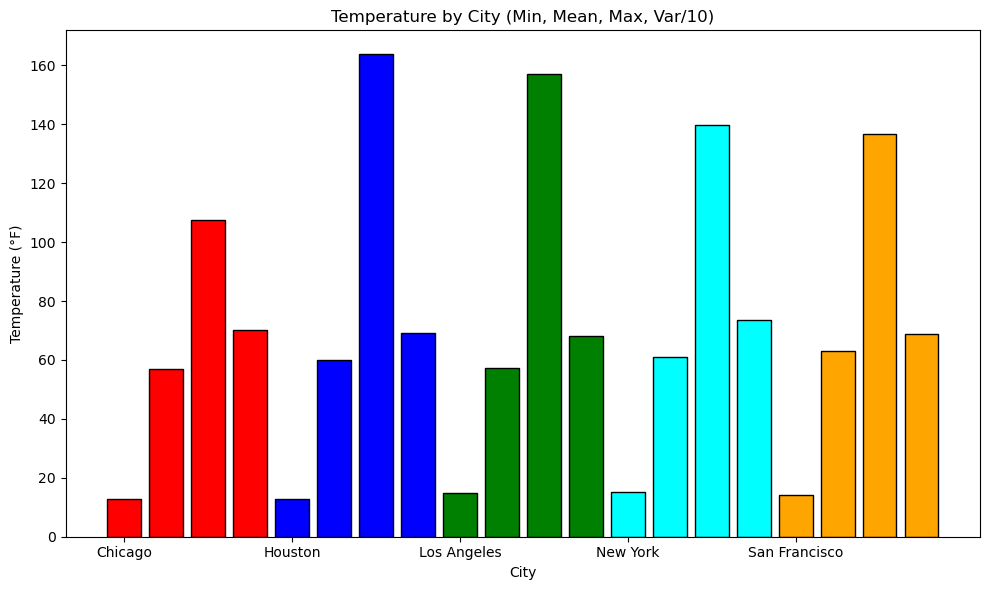

In [15]:
Graphs.grouped_bar_graph_var(locaiton_temperatures, list(locaiton_temperatures.keys()), 'City', 'Temperature (°F)', 10, 'Temperature by City')

In [16]:
encoded_location_temp = data.groupby('Charging Station Location')['Temperature (°C)'].apply(
    lambda temps: temps.apply(lambda t: 'Hot' if t > 30 else ('Normal' if t > 15 else 'Cold')).tolist()
)

encoded_location_temp

Charging Station Location
Chicago          [Normal, Normal, Hot, Cold, Cold, Hot, Normal,...
Houston          [Normal, Hot, Normal, Hot, Hot, Hot, Normal, C...
Los Angeles      [Cold, Cold, Normal, Cold, Cold, Cold, Hot, Co...
New York         [Cold, Hot, Cold, Hot, Hot, Hot, Cold, Cold, H...
San Francisco    [Cold, Normal, Cold, Hot, Normal, Normal, Cold...
Name: Temperature (°C), dtype: object

In [17]:
for city in list(encoded_location_temp.keys()):
    print(city)
    print(pd.Series(encoded_location_temp[city]).value_counts())

Chicago
Cold      116
Normal     58
Hot        37
dtype: int64
Houston
Cold      114
Normal     74
Hot        41
dtype: int64
Los Angeles
Cold      136
Normal     69
Hot        45
dtype: int64
New York
Cold      105
Normal     62
Hot        53
dtype: int64
San Francisco
Cold      99
Normal    66
Hot       56
dtype: int64


In [18]:
locaiton_charging_rates = data.groupby('Charging Station Location')['Charging Rate (kW)'].apply(lambda temps: [t for t in temps])
locaiton_charging_rates

Charging Station Location
Chicago          [11.76099971515701, 6.614280124746195, 19.1948...
Houston          [36.3891805669814, 32.882869757386224, 26.1851...
Los Angeles      [10.215712071204608, 26.7029077655282, 14.2949...
New York         [49.40273861566977, 20.49084604597367, 49.7103...
San Francisco    [30.67773493971444, 27.51359255877324, 14.3345...
Name: Charging Rate (kW), dtype: object

Generates Graphs of a given city and its charging rate


<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

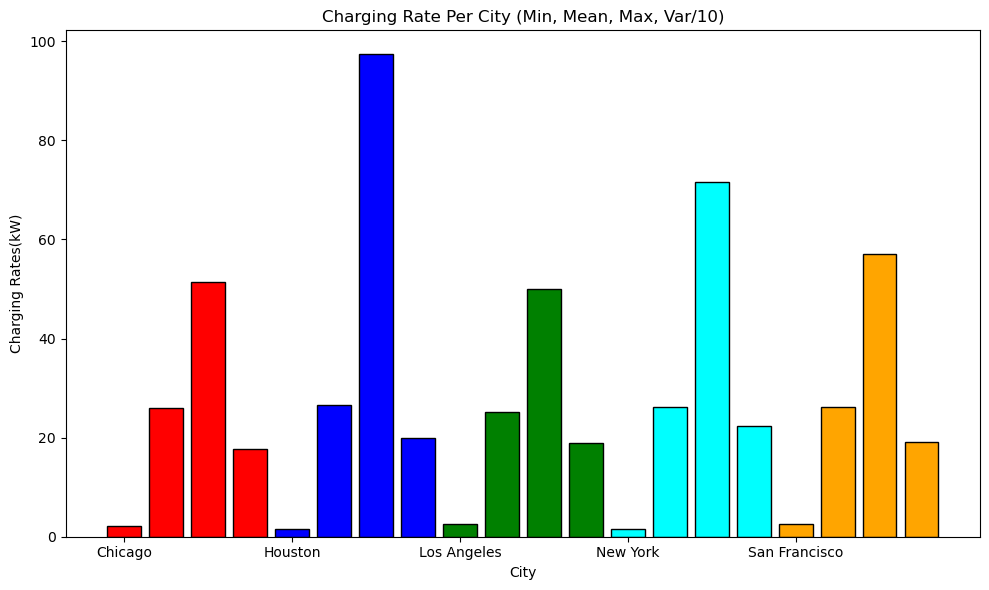

In [19]:
Graphs.grouped_bar_graph_var(locaiton_charging_rates, list(locaiton_charging_rates.keys()), 'City', 'Charging Rates(kW)', 10, 'Charging Rate Per City')

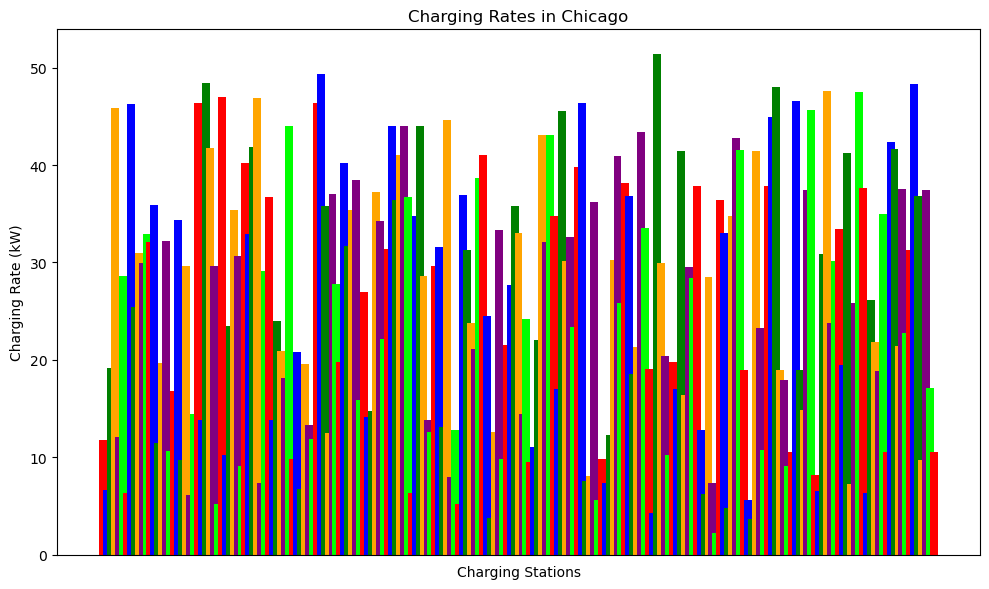

In [20]:
loc = 'Chicago'
charging_data = locaiton_charging_rates[loc]

# Define colors and cycle through them
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']
bar_colors = [colors[i % len(colors)] for i in range(len(charging_data))]


plt.figure(figsize=(10, 6))
plt.bar(range(len(charging_data)), charging_data, color=bar_colors, width=2)
plt.title(f'Charging Rates in {loc}')
plt.xlabel('Charging Stations')
plt.ylabel('Charging Rate (kW)')
plt.xticks([])
plt.tight_layout()

plt.show()

Generates a bar graph comparing the mean, low, and high of each city

In [21]:
locaiton_charger_types = data.groupby('Charging Station Location')['Charger Type'].apply(list)
locaiton_charger_types

Charging Station Location
Chicago          [DC Fast Charger, Level 2, DC Fast Charger, DC...
Houston          [DC Fast Charger, Level 1, Level 2, Level 2, L...
Los Angeles      [Level 1, Level 2, Level 1, DC Fast Charger, D...
New York         [DC Fast Charger, Level 1, DC Fast Charger, Le...
San Francisco    [Level 1, Level 2, DC Fast Charger, DC Fast Ch...
Name: Charger Type, dtype: object

Generates a bar graph of each charger type in each city


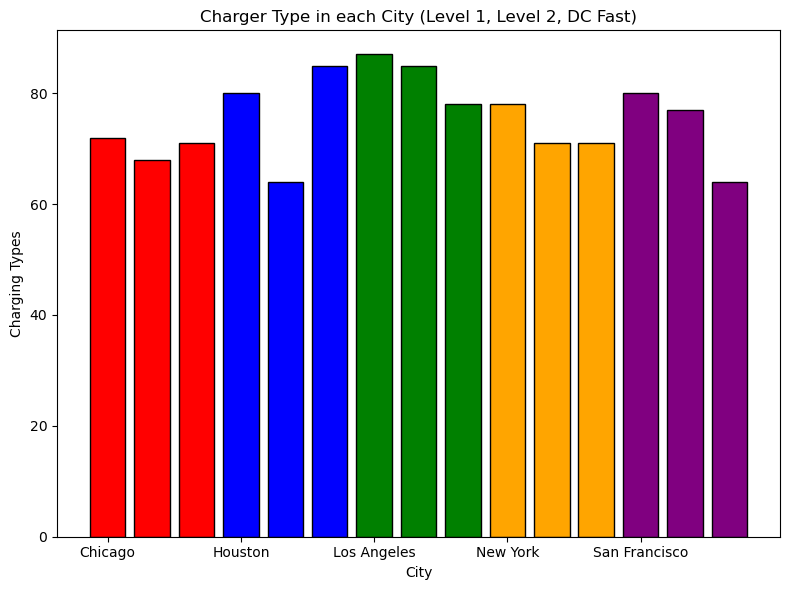

In [22]:
compare_charging_data = []
cities = list(locaiton_charger_types.keys())
city_labels = []
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, city in enumerate(cities):
    rates = locaiton_charger_types[city]
    vals = Counter(rates)
    compare_charging_data.extend([vals['Level 1'], vals['Level 2'], vals['DC Fast Charger']])
    city_labels.extend([city] * 3)

plt.figure(figsize=(8, 6))

bar_width = 0.8
positions = np.arange(len(compare_charging_data))

for i, city in enumerate(cities):
    city_position = positions[i * 3: (i + 1) * 3]
    plt.bar(city_position, compare_charging_data[i * 3:(i + 1) * 3], 
            color=colors[i], edgecolor='black', width=bar_width)

plt.title('Charger Type in each City (Level 1, Level 2, DC Fast)')
plt.xlabel('City')
plt.ylabel('Charging Types')

plt.xticks(ticks=np.arange(0, len(compare_charging_data), 3), labels=cities, rotation=0)
plt.tight_layout()
plt.show()

Generates a pie graph for each city's charger type distrbution


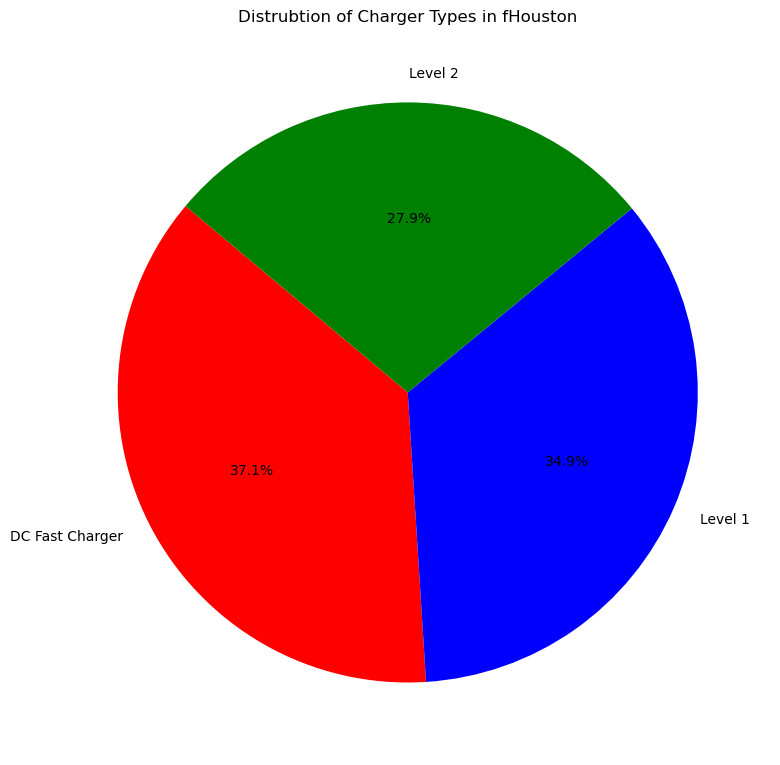

In [23]:
loc = 'Houston'
t_o_d = locaiton_charger_types[loc]
Graphs.pie_graph(t_o_d, f'Charger Types in f{loc}')

In [24]:
locaiton_charger_types_rates = data.groupby(['Charging Station Location', 'Charger Type'])['Charging Rate (kW)'].apply(list)
locaiton_charger_types_rates

Charging Station Location  Charger Type   
Chicago                    DC Fast Charger    [11.76099971515701, 19.194882837079632, 45.811...
                           Level 1            [12.064391459035129, 32.95451081519971, 10.621...
                           Level 2            [6.614280124746195, 6.35266144526304, 46.27844...
Houston                    DC Fast Charger    [36.3891805669814, 4.48564710517362, 34.458241...
                           Level 1            [32.882869757386224, 24.21115011711917, 11.238...
                           Level 2            [26.18518786003352, 19.76909871755716, 7.65157...
Los Angeles                DC Fast Charger    [10.310701112892176, 11.112498841670842, 16.91...
                           Level 1            [10.215712071204608, 14.294922926661108, 13.17...
                           Level 2            [26.7029077655282, 45.29143534649799, 30.48996...
New York                   DC Fast Charger    [49.40273861566977, 49.71030696901287, 38.4508.

Generates a bar graph for each charging rate per charger type in a city


<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

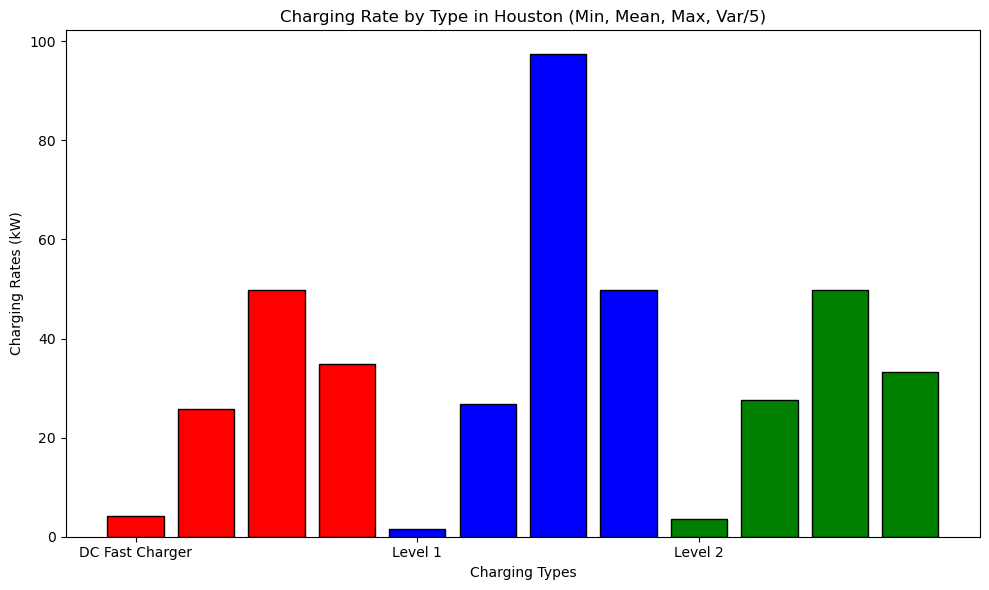

In [25]:
loc = 'Houston'
Graphs.grouped_bar_graph_var(locaiton_charger_types_rates[loc], list(locaiton_charger_types_rates[loc].keys()), 'Charging Types', 'Charging Rates (kW)', 5, f'Charging Rate by Type in {loc}')

In [26]:
locaiton_charger_types_costs = data.groupby(['Charging Station Location', 'Charger Type'])['Charging Cost (USD)'].apply(list)
locaiton_charger_types_costs

Charging Station Location  Charger Type   
Chicago                    DC Fast Charger    [21.312302451155745, 14.856131218606723, 33.13...
                           Level 1            [17.011782945517666, 18.02550998683417, 34.760...
                           Level 2            [6.430589211997161, 18.131831711875755, 18.849...
Houston                    DC Fast Charger    [13.087716791774506, 35.50300017025295, 9.7984...
                           Level 1            [13.036238833914622, 18.552815677456245, 24.03...
                           Level 2            [22.21422517569784, 37.44185660286842, 18.0343...
Los Angeles                DC Fast Charger    [38.221230704051806, 33.093492711055774, 10.60...
                           Level 1            [10.161471171031415, 32.465005072088225, 28.10...
                           Level 2            [9.796821321322032, 7.090844200594135, 28.8728...
New York                   DC Fast Charger    [17.49480846107398, 38.40606169605943, 15.8827.

Generates a bar graph for a city on the cost of charging using a charger type


<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

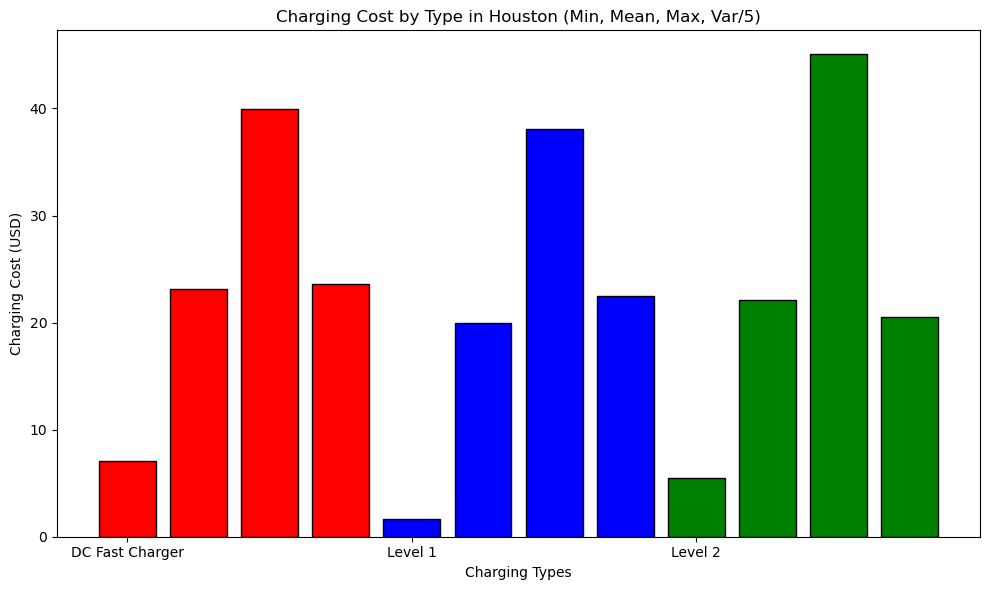

In [27]:
loc = 'Houston'
Graphs.grouped_bar_graph_var(locaiton_charger_types_costs[loc], list(locaiton_charger_types_costs[loc].keys()), 'Charging Types', 'Charging Cost (USD)', 5, f'Charging Cost by Type in {loc}')

In [28]:
locaiton_time_of_day = data.groupby('Charging Station Location')['Time of Day'].apply(list)
locaiton_time_of_day

Charging Station Location
Chicago          [Morning, Evening, Afternoon, Afternoon, Eveni...
Houston          [Evening, Evening, Evening, Morning, Afternoon...
Los Angeles      [Morning, Afternoon, Evening, Night, Evening, ...
New York         [Evening, Evening, Morning, Evening, Evening, ...
San Francisco    [Morning, Morning, Evening, Evening, Afternoon...
Name: Time of Day, dtype: object

Generates the time of day distrubtion pie graph for a given city


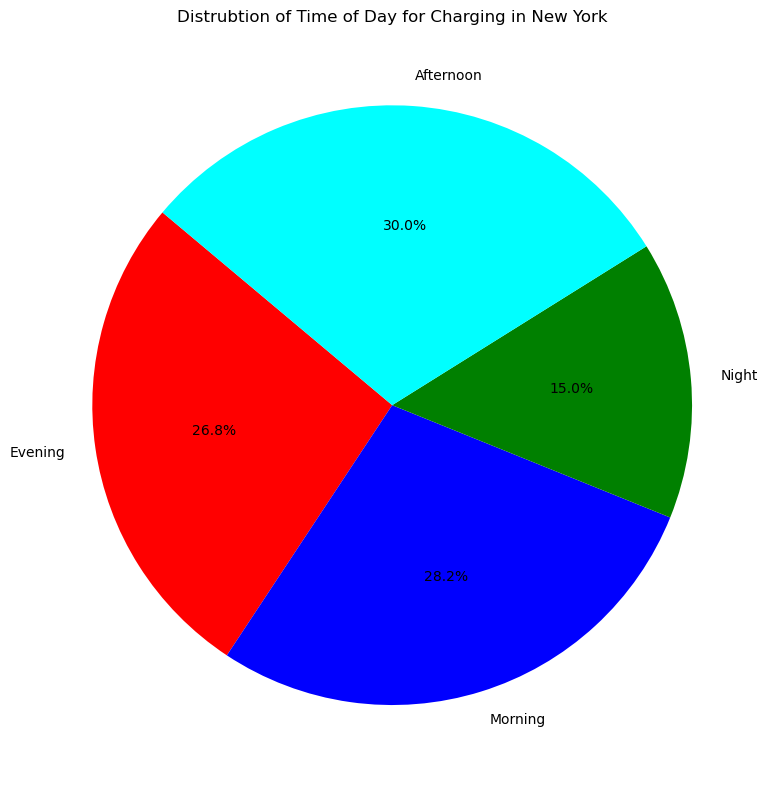

In [29]:
loc = 'New York'
t_o_d = locaiton_time_of_day[loc]
Graphs.pie_graph(t_o_d, f'Time of Day for Charging in {loc}')

In [30]:
locaiton_day_of_week = data.groupby('Charging Station Location')['Day of Week'].apply(list)
locaiton_day_of_week

Charging Station Location
Chicago          [Wednesday, Friday, Saturday, Friday, Wednesda...
Houston          [Tuesday, Saturday, Friday, Friday, Monday, We...
Los Angeles      [Saturday, Monday, Wednesday, Thursday, Monday...
New York         [Thursday, Saturday, Friday, Monday, Tuesday, ...
San Francisco    [Monday, Thursday, Saturday, Sunday, Monday, S...
Name: Day of Week, dtype: object

Generates a pie graph for day of weeks where charing occurs


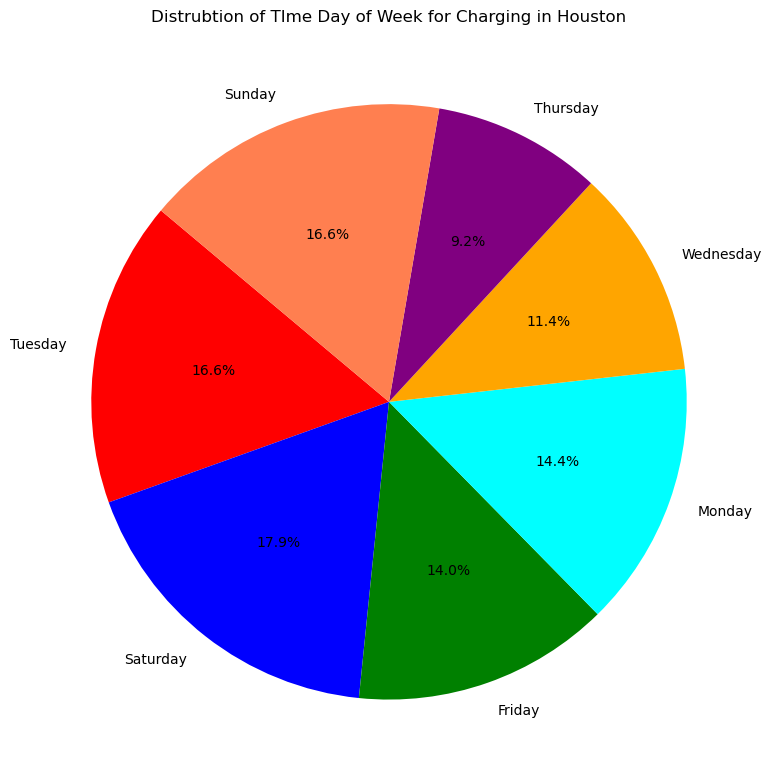

In [31]:
loc = 'Houston'
t_o_d = locaiton_day_of_week[loc]
Graphs.pie_graph(t_o_d, f'TIme Day of Week for Charging in {loc}')

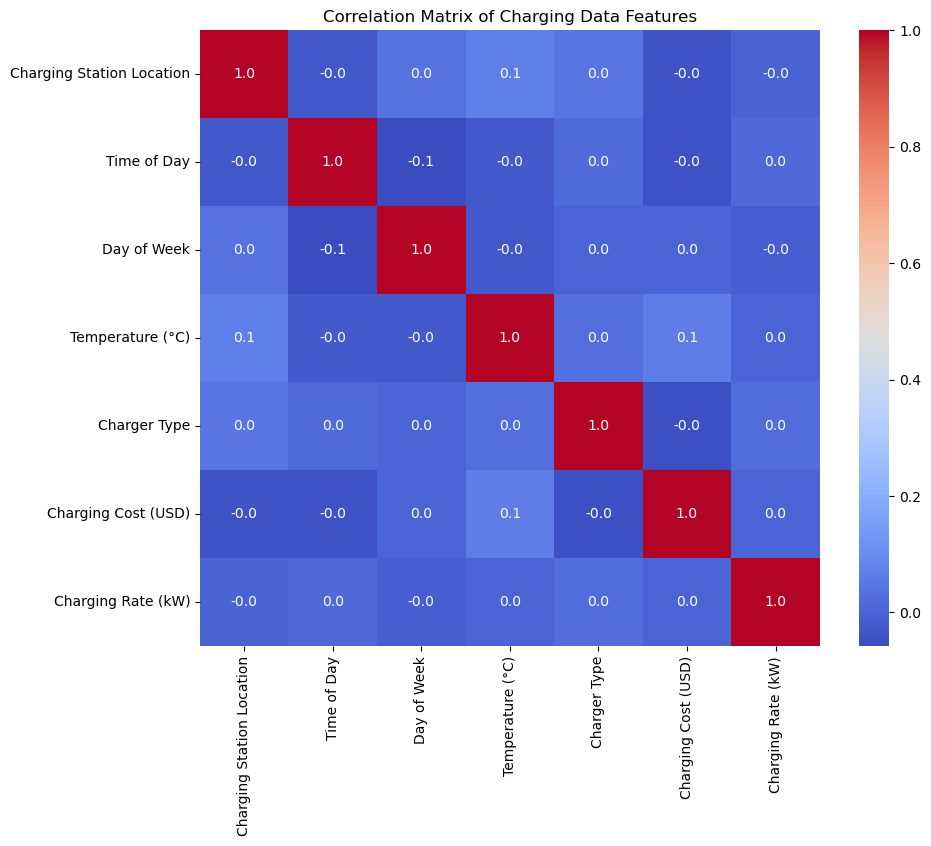

In [32]:
cols = ['Charging Station Location', 'Time of Day', 'Day of Week', 'Temperature (°C)', 'Charger Type', 'Charging Cost (USD)', 'Charging Rate (kW)']
d = data[cols].copy()

labels = {}

for col in ['Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type']:
    le = LabelEncoder()
    d[col] = le.fit_transform(d[col])
    labels[col] = le

mat = d.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Matrix of Charging Data Features")
plt.show()

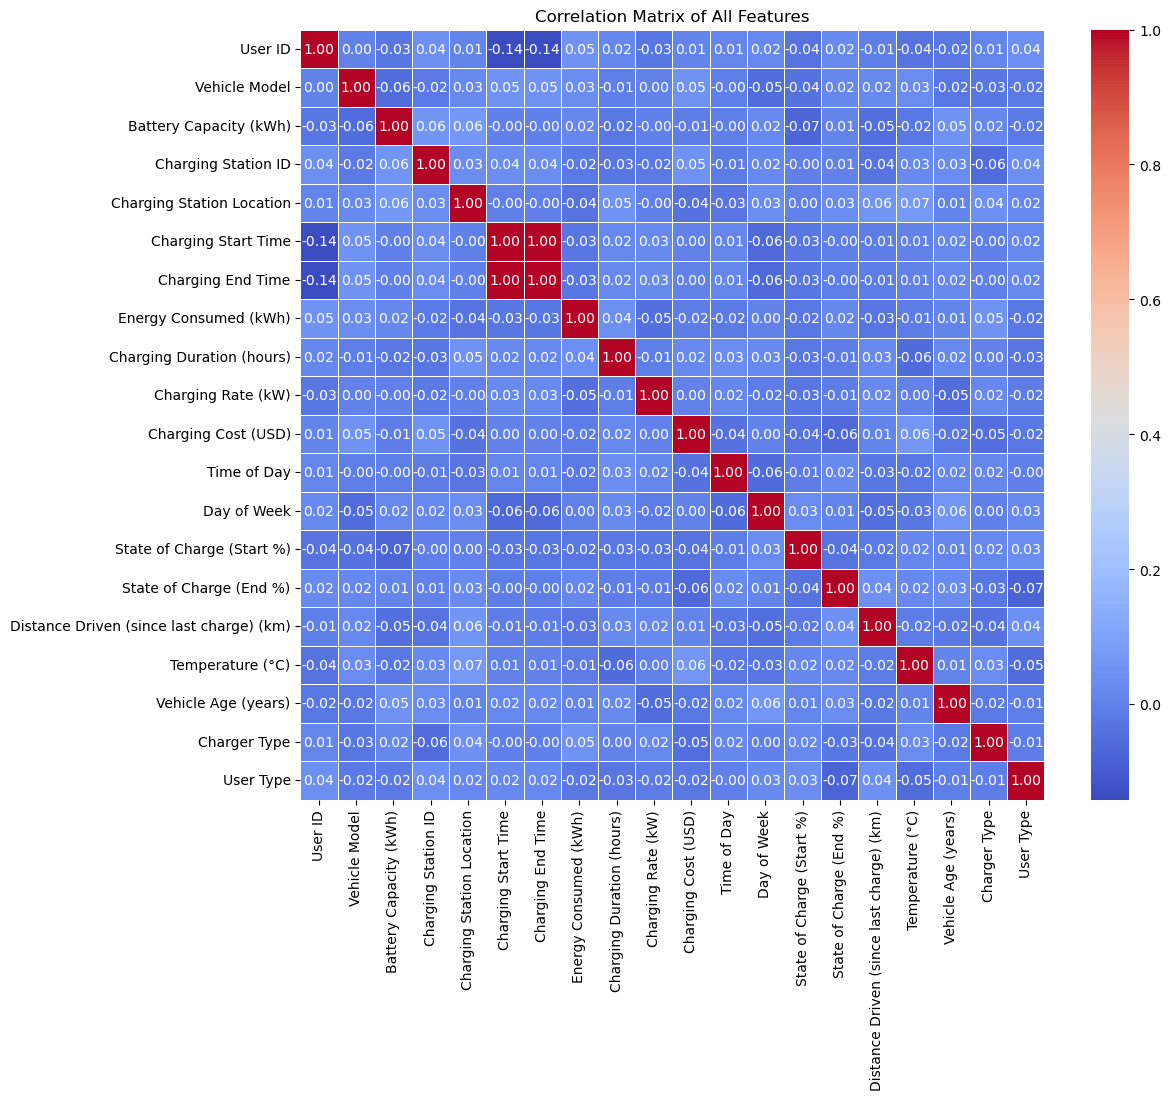

In [33]:
df = data.copy()
categorical_cols = df.select_dtypes(include=['object']).columns

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

mat = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features")
plt.show()

In [34]:
enhanced_data = data.copy()
enhanced_data['cost_per_kwh'] = enhanced_data['Energy Consumed (kWh)'] / enhanced_data['Charging Cost (USD)']
enhanced_data['charged_rates_per_hour'] = (enhanced_data['State of Charge (End %)'] - enhanced_data['State of Charge (Start %)']) / enhanced_data['Charging Duration (hours)']
mean = enhanced_data['cost_per_kwh'].mean()
std = enhanced_data['cost_per_kwh'].std()

# filter
enhanced_data = enhanced_data[(enhanced_data['cost_per_kwh'] >= mean - 3 * std) & (enhanced_data['cost_per_kwh'] <= mean + 3 * std)]
print(f"original data count: {len(data)}, after filter: {len(enhanced_data)}")
print(enhanced_data['charged_rates_per_hour'][:10])

original data count: 1131, after filter: 1129
0    95.961948
1    23.789676
2    25.712165
3    13.032157
4     4.696010
5    -2.770940
6     2.837683
7     2.856490
8    34.505914
9    21.044185
Name: charged_rates_per_hour, dtype: float64


In [35]:
locaiton_charging_unit_price = enhanced_data.groupby('Charging Station Location')['cost_per_kwh'].apply(list)
locaiton_charging_unit_price

Charging Station Location
Chicago          [3.7006141233225076, 3.7047989987073398, 3.311...
Houston          [4.638879852067387, 6.0951494522899, 1.6593934...
Los Angeles      [1.931718728257224, 5.25350163796334, 1.342749...
New York         [1.4133871620101668, 1.7001622440220514, 1.782...
San Francisco    [0.5840123820319596, 0.5363145391545282, 1.170...
Name: cost_per_kwh, dtype: object

<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

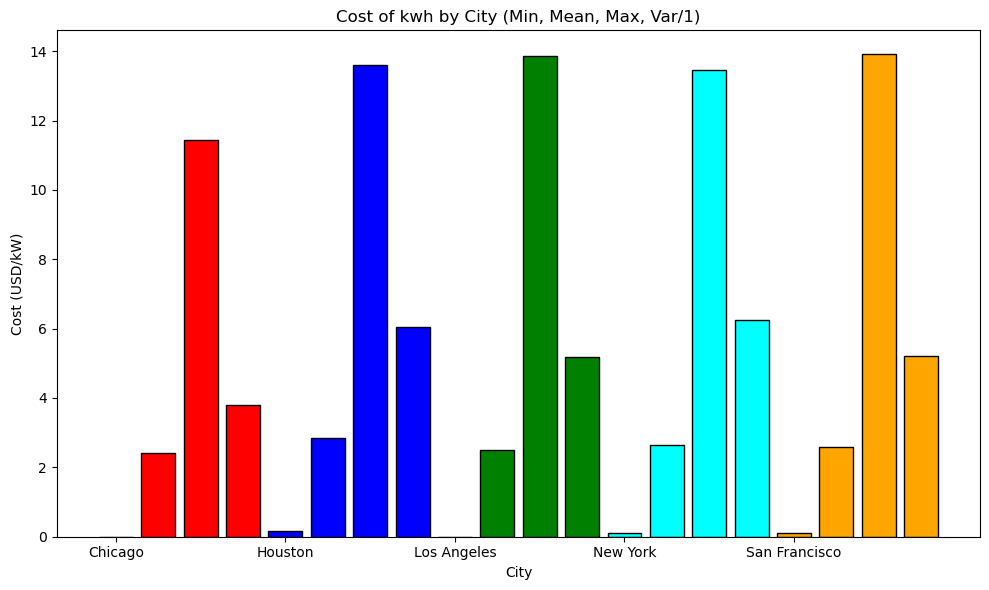

In [36]:
Graphs.grouped_bar_graph_var(locaiton_charging_unit_price, list(locaiton_charging_unit_price.keys()), 'City', 'Cost (USD/kW)', 1, 'Cost of kwh by City')

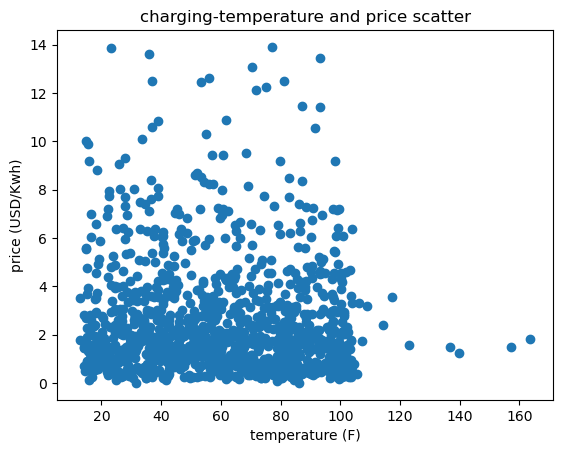

In [37]:
temperature_filtered_F = enhanced_data['Temperature (°C)']* 9/5 +32
plt.scatter(temperature_filtered_F, enhanced_data['cost_per_kwh'])

# 添加标题和坐标轴标签
plt.title('charging-temperature and price scatter')
plt.xlabel('temperature (F)')
plt.ylabel('price (USD/Kwh)')

# 显示图形
plt.show()

In [38]:
np.mean(enhanced_data['charged_rates_per_hour'])
negative_charger = enhanced_data[enhanced_data['charged_rates_per_hour'] < 0]
positive_charger = enhanced_data[enhanced_data['charged_rates_per_hour'] >= 0]
print(f"Original average of charging rates per hour: {np.mean(enhanced_data['charged_rates_per_hour'])}")
print(f"Average of negative chargers: {np.mean(negative_charger['charged_rates_per_hour'])} Count: {len(negative_charger)}")
print(f"Average of positive chargers: {np.mean(positive_charger['charged_rates_per_hour'])} Count: {len(positive_charger)}")

Original average of charging rates per hour: 15.328978615551847
Average of negative chargers: -9.505282960113265 Count: 238
Average of positive chargers: 21.962597308041502 Count: 891


In [39]:
negative_charger['Charging Station Location'].value_counts()

Los Angeles      64
Houston          50
New York         45
San Francisco    41
Chicago          38
Name: Charging Station Location, dtype: int64

In [40]:
mean = positive_charger['charged_rates_per_hour'].mean()
std = positive_charger['charged_rates_per_hour'].std()

# filter
filtered_positive_data = positive_charger[(positive_charger['charged_rates_per_hour'] >= mean - 3 * std) & (positive_charger['charged_rates_per_hour'] <= mean + 3 * std)]

<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

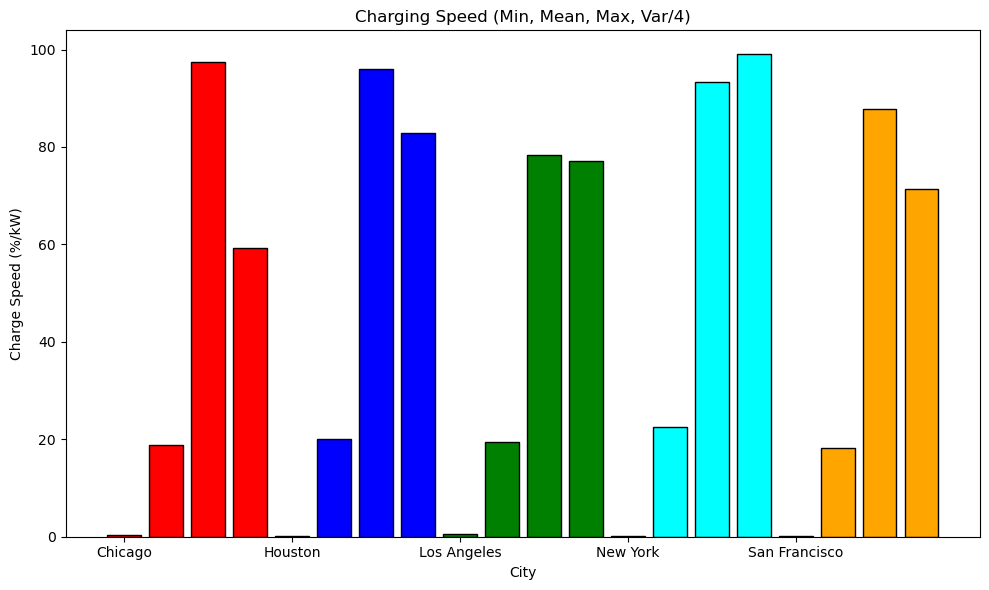

In [41]:
location_charging_unit_speed = filtered_positive_data.groupby('Charging Station Location')['charged_rates_per_hour'].apply(list)
Graphs.grouped_bar_graph_var(location_charging_unit_speed,list(location_charging_unit_speed.keys()), 'City', 'Charge Speed (%/kW)', 4, 'Charging Speed')

<module 'matplotlib.pyplot' from 'c:\\Users\\mjalb\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

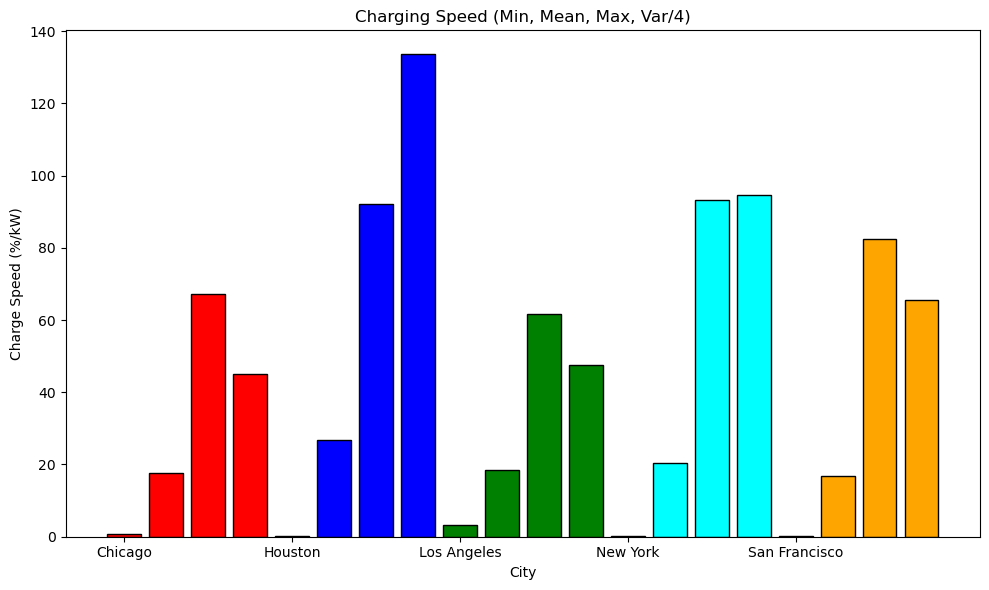

In [42]:
Tesla_data = filtered_positive_data[filtered_positive_data['Vehicle Model'] == "Tesla Model 3"]
location_charging_unit_speed = Tesla_data.groupby('Charging Station Location')['charged_rates_per_hour'].apply(list)
Graphs.grouped_bar_graph_var(location_charging_unit_speed,list(location_charging_unit_speed.keys()), 'City', 'Charge Speed (%/kW)', 4, 'Charging Speed')